In [1]:
import os, time, errno
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='0'
savedir = '32x32-convnet-descrambling'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root

try:
    dataset = np.load('captures/fei/cache.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)
    
classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [5]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(torch.nn.Module):
    def __init__(self, filters=512):
        super(ConvNet, self).__init__()
        self.filters = filters
        
        self.conv_in = torch.nn.Conv2d(1, filters, 9, padding=4, stride=4, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(101): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,1,64,64)[:,:,::2,::2].contiguous()
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])

# Fit

In [6]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.
order = np.random.permutation(range(64*64))

In [7]:
train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

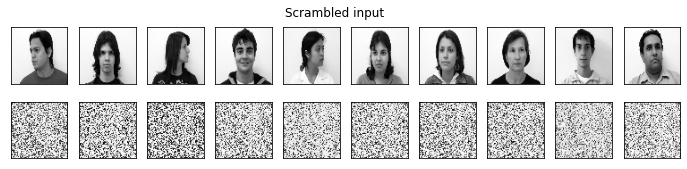

In [8]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Scrambled input')

for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(train_targets[i].view(-1)[order].view(64,64),cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])
    
# data is scrambled targets
data = targets.view(-1,64*64)[:,order].view(-1,1,64,64)
train_data = train_targets.view(-1,64*64)[:,order].view(-1,1,64,64)
val_data = val_targets.view(-1,64*64)[:,order].view(-1,1,64,64)
test_data = test_targets.view(-1,64*64)[:,order].view(-1,1,64,64)

In [9]:
batch_size = 8

model = ConvNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 476862977 parameters
Initial Loss: 4.070763


In [10]:
batch_size = 8
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	1.059962	0.782923	83.796937	2.198740
1	0.563315	0.460308	86.398894	2.260435
2	0.451285	0.467709	88.180120	2.289028
3	0.401921	0.408158	88.282049	2.274702
4	0.343433	0.352009	88.129601	2.269685
5	0.311753	0.320162	88.015423	2.266579
6	0.291475	0.430005	88.095960	2.262032
7	0.266944	0.298975	88.045002	2.277159
8	0.257486	0.272054	88.128210	2.270338
9	0.242105	0.274257	88.114252	2.277471
10	0.228434	0.243400	88.141268	2.283768
11	0.214402	0.285611	88.108430	2.277148
12	0.208555	0.271752	88.200116	2.255370
13	0.201403	0.226241	88.137564	2.273820
14	0.181855	0.242717	88.229330	2.270289
15	0.173099	0.306851	88.231112	2.281596
16	0.173581	0.226791	88.214931	2.287020
17	0.157563	0.269100	88.165742	2.273879
18	0.153723	0.206738	88.287602	2.274086
19	0.141892	0.214941	88.217189	2.267526
20	0.137929	0.200006	88.242389	2.287377
21	0.130293	0.203924	88.215055	2.273209
22	0.124146	0.231188	88.219578	2.275044
23	0.119573	0.283419	88.224666	2.274740
24	0.118520

202	0.004791	0.174131	87.300945	2.237433
203	0.005049	0.174599	87.413364	2.260270
204	0.004740	0.176348	87.938486	2.285124
205	0.004181	0.173305	88.071141	2.280158
206	0.003721	0.172774	88.211743	2.278385
207	0.003449	0.172188	88.130229	2.289370
208	0.003674	0.173564	88.175514	2.281276
209	0.004042	0.172869	88.115783	2.271039
210	0.004179	0.177720	88.246194	2.284981
211	0.004248	0.174303	88.120676	2.279769
212	0.004011	0.174307	88.123689	2.284839
213	0.003838	0.173409	88.196086	2.265374
214	0.003595	0.174617	88.054361	2.286608
215	0.003573	0.173073	88.220065	2.284969
216	0.003936	0.173368	88.119102	2.288891
217	0.004486	0.172973	88.129593	2.286360
218	0.004260	0.173825	88.205847	2.267940
219	0.004250	0.177173	88.243849	2.285957
220	0.003634	0.173902	87.887694	2.246915
221	0.003638	0.172702	87.205786	2.235870
222	0.003291	0.173190	87.494768	2.249735
223	0.003248	0.173726	87.867020	2.287622
224	0.003325	0.173561	88.005106	2.285196
225	0.003668	0.174572	88.048142	2.287901
226	0.004384	0.1

402	0.001835	0.173120	87.954242	2.265559
403	0.001942	0.172642	87.176725	2.238745
404	0.001991	0.173384	87.174675	2.259562
405	0.001979	0.172965	87.647555	2.250211
406	0.001915	0.173623	87.817982	2.262551
407	0.002043	0.173883	87.868526	2.254991
408	0.002217	0.172496	87.792946	2.269867
409	0.002009	0.172364	87.821410	2.266420
410	0.001778	0.173996	87.893044	2.267185
411	0.001513	0.173878	87.850558	2.289324
412	0.001387	0.172433	87.884629	2.286329
413	0.001381	0.172032	87.878507	2.288440
414	0.001539	0.173533	87.857880	2.264169
415	0.001728	0.173890	87.837110	2.288995
416	0.001884	0.173398	87.799504	2.266925
417	0.002004	0.172822	87.914029	2.259903
418	0.002046	0.174851	87.826502	2.283161
419	0.002005	0.173160	87.871644	2.282500
420	0.001933	0.171774	87.875204	2.268727
421	0.001711	0.171502	87.818491	2.280609
422	0.001592	0.171553	87.905770	2.272506
423	0.001593	0.172455	87.917002	2.275653
424	0.001670	0.173289	88.011981	2.269275
425	0.001704	0.172531	87.936018	2.286516
426	0.001718	0.1

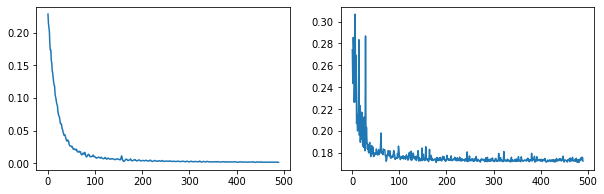

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(train_history[10:])
ax[1].plot(val_history[10:])

In [12]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 10.617656


In [52]:
try:
    os.makedirs(f'final-outputs/{savedir}')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

train_idx = 0
val_idx = 0
test_idx = 0
for i in range(len(data)):
    person, pose = classes[i]
    if (i+1) % 5 != 0: # training data
        prefix = f'train{train_idx}'
        train_idx += 1
    elif (i+1) % 10 == 5: # validation data
        prefix = f'valid{val_idx}'
        val_idx += 1
    else: # (i+1) % 10 == 0 (test data)
        prefix = f'test{test_idx}'
        test_idx += 1
    
    with torch.no_grad(): recon = model(data[i].cuda()).detach().cpu().numpy()[0]
    cv2.imwrite(f'final-outputs/{savedir}/{prefix}-person{person}-pose{pose}.png', 255*recon)

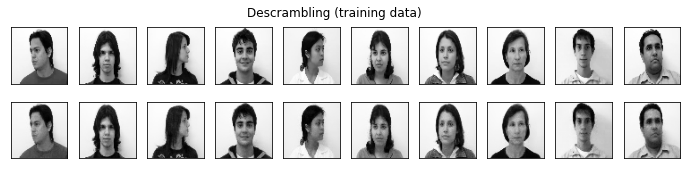

In [24]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Descrambling (training data)')

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

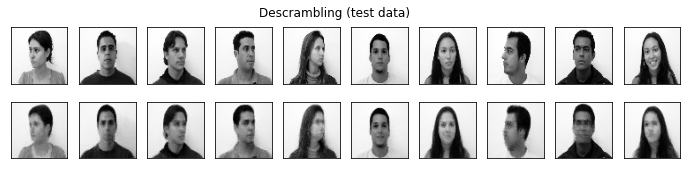

In [29]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Descrambling (test data)')

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])